# CNN
This is trained using accelerator GPU T4*2 on Kaggle

The dataset used for training and testing was downloaded from the LMS platform and uploaded to Kaggle manually. The folder structure is as follows:
```
2025_A2/
|- train/
|   |- img_000001.jpg
|   |- ...
|- test/
    |- img_005489.jpg
    |- ...
```

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import time
import os
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 1. Configuration

In [13]:
IMG_WIDTH = 48 # Target width for resizing images
IMG_HEIGHT = 48 # Target height for resizing images
IMG_CHANNELS = 3 # 3 for RGB
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 43 # Number of road sign classes
LEARNING_RATE = 0.001
PATIENCE_EARLY_STOPPING = 10 # For EarlyStopping
PATIENCE_LR_SCHEDULER = 5  # For ReduceLROnPlateau

BASE_TRAIN_DIR = '/kaggle/input/25s1-comp30027-ml-a2/2025_A2/train/'
BASE_TEST_DIR = '/kaggle/input/25s1-comp30027-ml-a2/2025_A2/test/'
MODEL_SAVE_PATH = '/kaggle/working/pytorch_cnn_road_sign_model.pth'
SUBMISSION_SAVE_PATH = '/kaggle/working/submission_pytorch_cnn.csv'

# Check for GPU availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Load Images

In [14]:
class RoadSignDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None, mode='train'):
        self.df = dataframe # DataFrame with image_path and ClassId (for train/val) or id (for test)
        self.base_dir = base_dir # Base directory where images are located (train/ or test/)
        self.transform = transform
        self.mode = mode # 'train', 'val', or 'test'

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        img_relative_path = self.df.iloc[idx]['image_path'] # Construct full image path
        img_full_path = os.path.join(self.base_dir, img_relative_path)
    
        image = None
        try:
            image = read_image(img_full_path, mode=ImageReadMode.RGB)
        except Exception as e_torchvision:
            print(f"Torchvision read_image failed for {img_full_path}: {e_torchvision}. Falling back to PIL.")
            try:
                # Use PIL to load and convert image to RGB
                image_pil = Image.open(img_full_path).convert('RGB')
                image = np.array(image_pil) 
                image = torch.from_numpy(image.transpose((2, 0, 1))) 
            except Exception as e_pil:
                print(f"Critical error loading image {img_full_path} with PIL: {e_pil}")
                dummy_image_tensor = torch.zeros((IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH), dtype=torch.uint8)
                if self.mode == 'test':
                    sample_id = self.df.iloc[idx].get('id', f"error_id_{idx}")
                    # Ensure img_relative_path is defined even in error for consistent return signature
                    return dummy_image_tensor, sample_id, img_relative_path 
                else:
                    return dummy_image_tensor, -1 
    
        if self.transform:
            image = self.transform(image)
    
        if self.mode == 'test':
            sample_id = self.df.iloc[idx].get('id', f"error_id_{idx}") 
            return image, sample_id, img_relative_path
        else:
            label = int(self.df.iloc[idx]['ClassId'])
            return image, label

## 3. Image Transformations

In [15]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert from uint8 tensor to PIL Image
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(), # Converts PIL image (H,W,C) in range [0,255] to (C,H,W) float tensor in range [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize to [-1,1]
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert from uint8 tensor to PIL Image
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(), # Converts PIL image to float tensor in range [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize to [-1,1]
])

## 4. Define CNN Model

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        dummy_input = torch.randn(1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)
        dummy_output = self.conv_layers(dummy_input)
        self.flattened_size = int(np.prod(dummy_output.size()[1:]))

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes) # Output layer, CrossEntropyLoss will apply softmax
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## 5. Training and Validation Functions

In [17]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch_num):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_num+1}/{EPOCHS} [Training]")
    for inputs, labels in progress_bar:
        # Filter out bad images (label == -1)
        valid_indices = labels != -1
        if not valid_indices.any():
            continue
        inputs, labels = inputs[valid_indices], labels[valid_indices]

        inputs, labels = inputs.to(device), labels.to(device).long() # Ensure labels are LongTensor

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        progress_bar.set_postfix(loss=running_loss/total_samples, acc=correct_predictions.double()/total_samples)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc

In [18]:
def validate_one_epoch(model, dataloader, criterion, device, epoch_num):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_num+1}/{EPOCHS} [Validation]")
    with torch.no_grad():
        for inputs, labels in progress_bar:
            # Filter out bad images
            valid_indices = labels != -1
            if not valid_indices.any():
                continue
                
            inputs, labels = inputs[valid_indices], labels[valid_indices]
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            progress_bar.set_postfix(loss=running_loss/total_samples, acc=correct_predictions.double()/total_samples)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc

## 6. Plot Confusion Matrix

In [19]:
def plot_confusion_matrix(val_loader, device):
    print("\n--- Generating Confusion Matrix for Best Model on Validation Set ---")

    # Initialize model
    model = SimpleCNN().to(device)
    try:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    except FileNotFoundError:
        print(f"ERROR: Model not found at {MODEL_SAVE_PATH}.")
        return
    except Exception as e:
        print(f"Error loading model for confusion matrix: {e}")
        return
    model.eval()

    all_preds_cm = []
    all_labels_cm = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Getting Validation Predictions for CM"):
            # Filter out bad images (label == -1)
            valid_indices = labels != -1
            if not valid_indices.any():
                continue
            inputs, labels = inputs[valid_indices], labels[valid_indices]

            inputs = inputs.to(device)
            labels = labels.to(device).long()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds_cm.extend(preds.cpu().numpy())
            all_labels_cm.extend(labels.cpu().numpy())

    if not all_labels_cm or not all_preds_cm:
        print("No valid samples found in validation set to generate confusion matrix.")
        return

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(all_labels_cm, all_preds_cm)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - CNN')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

## 7. Main Training Loop

In [20]:
def run_training():
    print("\n--- Initializing Training ---")
    # Load dataset info
    train_val_df_info = pd.read_csv(os.path.join(BASE_TRAIN_DIR, 'train_metadata.csv'))
    if train_val_df_info is None or train_val_df_info.empty:
        print("Could not load training metadata. Exiting.")
        return

    # Split into training and validation sets
    train_df, val_df = train_test_split(
        train_val_df_info,
        test_size=0.2,
        random_state=42,
        stratify=train_val_df_info['ClassId']
    )
    print(f"Training set size: {len(train_df)}, Validation set size: {len(val_df)}")

    # Create Datasets and DataLoaders
    train_dataset = RoadSignDataset(train_df, BASE_TRAIN_DIR, transform=train_transforms, mode='train')
    val_dataset = RoadSignDataset(val_df, BASE_TRAIN_DIR, transform=val_test_transforms, mode='val')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model, criterion, optimizer
    model = SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=PATIENCE_LR_SCHEDULER)

    best_val_accuracy = 0.0
    epochs_no_improve = 0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("\n--- Starting Training Loop ---")
    start_time_total = time.time()
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, epoch)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, DEVICE, epoch)
        epoch_duration = time.time() - epoch_start_time

        print(f"Epoch {epoch+1}/{EPOCHS}\n"
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}\n"
              f"- Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n"
              f"- LR: {optimizer.param_groups[0]['lr']:.1e}\n"
              f"- Duration: {epoch_duration:.2f}s")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item() if torch.is_tensor(train_acc) else train_acc) # Ensure float for plotting
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item() if torch.is_tensor(val_acc) else val_acc) # Ensure float

        scheduler.step(val_loss) # ReduceLROnPlateau steps on validation loss

        if val_acc > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_acc:.4f}. Saving model...")
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"Validation accuracy did not improve. Current best: {best_val_accuracy:.4f}. Epochs without improvement: {epochs_no_improve}.")

        if epochs_no_improve >= PATIENCE_EARLY_STOPPING:
            print(f"Early stopping triggered after {PATIENCE_EARLY_STOPPING} epochs without improvement.")
            break
            
    total_training_time = time.time() - start_time_total
    print(f"\n--- Training Finished --- Total Time: {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

    # Plot training history
    plt.figure(figsize=(6, 10))
    plt.subplot(2, 1, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

    # Plot confusion matrix
    plot_confusion_matrix(val_loader, DEVICE)

## 8. Predict on Test Set

In [21]:
def predict_and_create_submission():
    print("\n--- Predicting on Test Set ---")

    # Load test metadata
    test_metadata_df = pd.read_csv(os.path.join(BASE_TEST_DIR, 'test_metadata.csv'))
    test_dataset = RoadSignDataset(test_metadata_df, BASE_TEST_DIR, transform=val_test_transforms, mode='test')
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count() // 2 or 1)

    # Load trained model
    print(f"Loading model from: {MODEL_SAVE_PATH}")
    model = SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE)
    try:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    except FileNotFoundError:
        print(f"ERROR: Model not found at {MODEL_SAVE_PATH}")
        return
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    model.eval()
    all_predictions, all_ids, all_paths = [], [], []

    # Make predictions
    with torch.no_grad():
        for inputs, ids, paths in tqdm(test_loader, desc="Predicting"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_predictions.extend(preds.cpu().numpy())
            all_ids.extend(ids.cpu().tolist() if torch.is_tensor(ids) else ids)
            all_paths.extend(paths)

    print(f"Predictions made: {len(all_predictions)}")

    # Map image paths to predictions
    path_to_pred = {path: pred for path, pred in zip(all_paths, all_predictions)}

    # Create submission
    test_metadata_df['id'] = test_metadata_df['id'].astype(str)
    final_preds = []
    final_ids = []

    for _, row in test_metadata_df.iterrows():
        img_id = str(row['id'])
        path = row['image_path']
        final_ids.append(img_id)
        final_preds.append(path_to_pred.get(path, 0))  # Default to class 0 if missing

    submission_df = pd.DataFrame({'id': final_ids, 'ClassId': final_preds})
    submission_df.to_csv(SUBMISSION_SAVE_PATH, index=False)

    print(f"Submission saved to {SUBMISSION_SAVE_PATH}")

## 9. Execution


--- Initializing Training ---
Training set size: 4390, Validation set size: 1098

--- Starting Training Loop ---


Epoch 1/50 [Validation]: 100%|██████████| 18/18 [00:02<00:00,  8.56it/s, acc=tensor(0.4308, device='cuda:0', dtype=torch.float64), loss=1.89]


Epoch 1/50
- Train Loss: 2.9428, Train Acc: 0.2435
- Val Loss: 1.8949, Val Acc: 0.4308
- LR: 1.0e-03
- Duration: 11.41s
Validation accuracy improved from 0.0000 to 0.4308. Saving model...


Epoch 2/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.70it/s, acc=tensor(0.6557, device='cuda:0', dtype=torch.float64), loss=1.2] 


Epoch 2/50
- Train Loss: 1.8153, Train Acc: 0.4811
- Val Loss: 1.1997, Val Acc: 0.6557
- LR: 1.0e-03
- Duration: 8.00s
Validation accuracy improved from 0.4308 to 0.6557. Saving model...


Epoch 3/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.22it/s, acc=tensor(0.7149, device='cuda:0', dtype=torch.float64), loss=1.42]


Epoch 3/50
- Train Loss: 1.2668, Train Acc: 0.6308
- Val Loss: 1.4152, Val Acc: 0.7149
- LR: 1.0e-03
- Duration: 8.06s
Validation accuracy improved from 0.6557 to 0.7149. Saving model...


Epoch 4/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.36it/s, acc=tensor(0.8525, device='cuda:0', dtype=torch.float64), loss=0.498]


Epoch 4/50
- Train Loss: 0.9238, Train Acc: 0.7378
- Val Loss: 0.4983, Val Acc: 0.8525
- LR: 1.0e-03
- Duration: 8.38s
Validation accuracy improved from 0.7149 to 0.8525. Saving model...


Epoch 5/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.18it/s, acc=tensor(0.9271, device='cuda:0', dtype=torch.float64), loss=0.316]


Epoch 5/50
- Train Loss: 0.6179, Train Acc: 0.8248
- Val Loss: 0.3164, Val Acc: 0.9271
- LR: 1.0e-03
- Duration: 7.96s
Validation accuracy improved from 0.8525 to 0.9271. Saving model...


Epoch 6/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 11.72it/s, acc=tensor(0.9454, device='cuda:0', dtype=torch.float64), loss=0.211]


Epoch 6/50
- Train Loss: 0.4546, Train Acc: 0.8756
- Val Loss: 0.2111, Val Acc: 0.9454
- LR: 1.0e-03
- Duration: 8.32s
Validation accuracy improved from 0.9271 to 0.9454. Saving model...


Epoch 7/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 11.90it/s, acc=tensor(0.9636, device='cuda:0', dtype=torch.float64), loss=0.141]


Epoch 7/50
- Train Loss: 0.3456, Train Acc: 0.9087
- Val Loss: 0.1408, Val Acc: 0.9636
- LR: 1.0e-03
- Duration: 10.02s
Validation accuracy improved from 0.9454 to 0.9636. Saving model...


Epoch 8/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.61it/s, acc=tensor(0.9681, device='cuda:0', dtype=torch.float64), loss=0.12] 


Epoch 8/50
- Train Loss: 0.2806, Train Acc: 0.9235
- Val Loss: 0.1204, Val Acc: 0.9681
- LR: 1.0e-03
- Duration: 8.51s
Validation accuracy improved from 0.9636 to 0.9681. Saving model...


Epoch 9/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.75it/s, acc=tensor(0.9718, device='cuda:0', dtype=torch.float64), loss=0.104]


Epoch 9/50
- Train Loss: 0.2333, Train Acc: 0.9378
- Val Loss: 0.1038, Val Acc: 0.9718
- LR: 1.0e-03
- Duration: 7.99s
Validation accuracy improved from 0.9681 to 0.9718. Saving model...


Epoch 10/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.09it/s, acc=tensor(0.9672, device='cuda:0', dtype=torch.float64), loss=0.107]


Epoch 10/50
- Train Loss: 0.2017, Train Acc: 0.9467
- Val Loss: 0.1066, Val Acc: 0.9672
- LR: 1.0e-03
- Duration: 8.20s
Validation accuracy did not improve. Current best: 0.9718. Epochs without improvement: 1.


Epoch 11/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.02it/s, acc=tensor(0.9526, device='cuda:0', dtype=torch.float64), loss=0.18] 


Epoch 11/50
- Train Loss: 0.1732, Train Acc: 0.9551
- Val Loss: 0.1797, Val Acc: 0.9526
- LR: 1.0e-03
- Duration: 7.87s
Validation accuracy did not improve. Current best: 0.9718. Epochs without improvement: 2.


Epoch 12/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.38it/s, acc=tensor(0.9690, device='cuda:0', dtype=torch.float64), loss=0.133]


Epoch 12/50
- Train Loss: 0.1640, Train Acc: 0.9595
- Val Loss: 0.1328, Val Acc: 0.9690
- LR: 1.0e-03
- Duration: 7.93s
Validation accuracy did not improve. Current best: 0.9718. Epochs without improvement: 3.


Epoch 13/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.87it/s, acc=tensor(0.9836, device='cuda:0', dtype=torch.float64), loss=0.0706]


Epoch 13/50
- Train Loss: 0.1671, Train Acc: 0.9590
- Val Loss: 0.0706, Val Acc: 0.9836
- LR: 1.0e-03
- Duration: 7.96s
Validation accuracy improved from 0.9718 to 0.9836. Saving model...


Epoch 14/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.26it/s, acc=tensor(0.9754, device='cuda:0', dtype=torch.float64), loss=0.071] 


Epoch 14/50
- Train Loss: 0.1449, Train Acc: 0.9617
- Val Loss: 0.0710, Val Acc: 0.9754
- LR: 1.0e-03
- Duration: 8.09s
Validation accuracy did not improve. Current best: 0.9836. Epochs without improvement: 1.


Epoch 15/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.23it/s, acc=tensor(0.9663, device='cuda:0', dtype=torch.float64), loss=0.0947]


Epoch 15/50
- Train Loss: 0.1138, Train Acc: 0.9706
- Val Loss: 0.0947, Val Acc: 0.9663
- LR: 1.0e-03
- Duration: 8.22s
Validation accuracy did not improve. Current best: 0.9836. Epochs without improvement: 2.


Epoch 16/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.95it/s, acc=tensor(0.9718, device='cuda:0', dtype=torch.float64), loss=0.106]


Epoch 16/50
- Train Loss: 0.1088, Train Acc: 0.9708
- Val Loss: 0.1060, Val Acc: 0.9718
- LR: 1.0e-03
- Duration: 8.33s
Validation accuracy did not improve. Current best: 0.9836. Epochs without improvement: 3.


Epoch 17/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.63it/s, acc=tensor(0.9772, device='cuda:0', dtype=torch.float64), loss=0.0686]


Epoch 17/50
- Train Loss: 0.1052, Train Acc: 0.9727
- Val Loss: 0.0686, Val Acc: 0.9772
- LR: 1.0e-03
- Duration: 8.03s
Validation accuracy did not improve. Current best: 0.9836. Epochs without improvement: 4.


Epoch 18/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.23it/s, acc=tensor(0.9699, device='cuda:0', dtype=torch.float64), loss=0.104] 


Epoch 18/50
- Train Loss: 0.1049, Train Acc: 0.9688
- Val Loss: 0.1039, Val Acc: 0.9699
- LR: 1.0e-03
- Duration: 7.87s
Validation accuracy did not improve. Current best: 0.9836. Epochs without improvement: 5.


Epoch 19/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.21it/s, acc=tensor(0.9781, device='cuda:0', dtype=torch.float64), loss=0.0617]


Epoch 19/50
- Train Loss: 0.0985, Train Acc: 0.9731
- Val Loss: 0.0617, Val Acc: 0.9781
- LR: 1.0e-03
- Duration: 7.88s
Validation accuracy did not improve. Current best: 0.9836. Epochs without improvement: 6.


Epoch 20/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.36it/s, acc=tensor(0.9763, device='cuda:0', dtype=torch.float64), loss=0.0951]


Epoch 20/50
- Train Loss: 0.1043, Train Acc: 0.9690
- Val Loss: 0.0951, Val Acc: 0.9763
- LR: 1.0e-03
- Duration: 7.96s
Validation accuracy did not improve. Current best: 0.9836. Epochs without improvement: 7.


Epoch 21/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.72it/s, acc=tensor(0.9891, device='cuda:0', dtype=torch.float64), loss=0.0428]


Epoch 21/50
- Train Loss: 0.0791, Train Acc: 0.9777
- Val Loss: 0.0428, Val Acc: 0.9891
- LR: 1.0e-03
- Duration: 8.02s
Validation accuracy improved from 0.9836 to 0.9891. Saving model...


Epoch 22/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.66it/s, acc=tensor(0.9845, device='cuda:0', dtype=torch.float64), loss=0.0541]


Epoch 22/50
- Train Loss: 0.0757, Train Acc: 0.9770
- Val Loss: 0.0541, Val Acc: 0.9845
- LR: 1.0e-03
- Duration: 8.07s
Validation accuracy did not improve. Current best: 0.9891. Epochs without improvement: 1.


Epoch 23/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.75it/s, acc=tensor(0.9827, device='cuda:0', dtype=torch.float64), loss=0.0682]


Epoch 23/50
- Train Loss: 0.0664, Train Acc: 0.9834
- Val Loss: 0.0682, Val Acc: 0.9827
- LR: 1.0e-03
- Duration: 8.04s
Validation accuracy did not improve. Current best: 0.9891. Epochs without improvement: 2.


Epoch 24/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.33it/s, acc=tensor(0.9727, device='cuda:0', dtype=torch.float64), loss=0.107] 


Epoch 24/50
- Train Loss: 0.0640, Train Acc: 0.9820
- Val Loss: 0.1069, Val Acc: 0.9727
- LR: 1.0e-03
- Duration: 8.21s
Validation accuracy did not improve. Current best: 0.9891. Epochs without improvement: 3.


Epoch 25/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.70it/s, acc=tensor(0.9781, device='cuda:0', dtype=torch.float64), loss=0.0741]


Epoch 25/50
- Train Loss: 0.0624, Train Acc: 0.9820
- Val Loss: 0.0741, Val Acc: 0.9781
- LR: 1.0e-03
- Duration: 8.11s
Validation accuracy did not improve. Current best: 0.9891. Epochs without improvement: 4.


Epoch 26/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.90it/s, acc=tensor(0.9791, device='cuda:0', dtype=torch.float64), loss=0.0683]


Epoch 26/50
- Train Loss: 0.0756, Train Acc: 0.9790
- Val Loss: 0.0683, Val Acc: 0.9791
- LR: 1.0e-03
- Duration: 8.06s
Validation accuracy did not improve. Current best: 0.9891. Epochs without improvement: 5.


Epoch 27/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.28it/s, acc=tensor(0.9863, device='cuda:0', dtype=torch.float64), loss=0.0483]


Epoch 27/50
- Train Loss: 0.0720, Train Acc: 0.9779
- Val Loss: 0.0483, Val Acc: 0.9863
- LR: 1.0e-03
- Duration: 7.87s
Validation accuracy did not improve. Current best: 0.9891. Epochs without improvement: 6.


Epoch 28/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.40it/s, acc=tensor(0.9891, device='cuda:0', dtype=torch.float64), loss=0.0431]


Epoch 28/50
- Train Loss: 0.0492, Train Acc: 0.9854
- Val Loss: 0.0431, Val Acc: 0.9891
- LR: 2.0e-04
- Duration: 8.09s
Validation accuracy did not improve. Current best: 0.9891. Epochs without improvement: 7.


Epoch 29/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.61it/s, acc=tensor(0.9900, device='cuda:0', dtype=torch.float64), loss=0.0373]


Epoch 29/50
- Train Loss: 0.0382, Train Acc: 0.9902
- Val Loss: 0.0373, Val Acc: 0.9900
- LR: 2.0e-04
- Duration: 8.06s
Validation accuracy improved from 0.9891 to 0.9900. Saving model...


Epoch 30/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.66it/s, acc=tensor(0.9882, device='cuda:0', dtype=torch.float64), loss=0.0464]


Epoch 30/50
- Train Loss: 0.0311, Train Acc: 0.9913
- Val Loss: 0.0464, Val Acc: 0.9882
- LR: 2.0e-04
- Duration: 7.91s
Validation accuracy did not improve. Current best: 0.9900. Epochs without improvement: 1.


Epoch 31/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.91it/s, acc=tensor(0.9909, device='cuda:0', dtype=torch.float64), loss=0.0343]


Epoch 31/50
- Train Loss: 0.0278, Train Acc: 0.9934
- Val Loss: 0.0343, Val Acc: 0.9909
- LR: 2.0e-04
- Duration: 8.01s
Validation accuracy improved from 0.9900 to 0.9909. Saving model...


Epoch 32/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.45it/s, acc=tensor(0.9909, device='cuda:0', dtype=torch.float64), loss=0.0308]


Epoch 32/50
- Train Loss: 0.0267, Train Acc: 0.9945
- Val Loss: 0.0308, Val Acc: 0.9909
- LR: 2.0e-04
- Duration: 8.16s
Validation accuracy did not improve. Current best: 0.9909. Epochs without improvement: 1.


Epoch 33/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.11it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0293]


Epoch 33/50
- Train Loss: 0.0233, Train Acc: 0.9952
- Val Loss: 0.0293, Val Acc: 0.9918
- LR: 2.0e-04
- Duration: 8.13s
Validation accuracy improved from 0.9909 to 0.9918. Saving model...


Epoch 34/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.12it/s, acc=tensor(0.9891, device='cuda:0', dtype=torch.float64), loss=0.0307]


Epoch 34/50
- Train Loss: 0.0255, Train Acc: 0.9932
- Val Loss: 0.0307, Val Acc: 0.9891
- LR: 2.0e-04
- Duration: 8.00s
Validation accuracy did not improve. Current best: 0.9918. Epochs without improvement: 1.


Epoch 35/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.75it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0257]


Epoch 35/50
- Train Loss: 0.0254, Train Acc: 0.9941
- Val Loss: 0.0257, Val Acc: 0.9918
- LR: 2.0e-04
- Duration: 7.77s
Validation accuracy did not improve. Current best: 0.9918. Epochs without improvement: 2.


Epoch 36/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.13it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0425]


Epoch 36/50
- Train Loss: 0.0239, Train Acc: 0.9954
- Val Loss: 0.0425, Val Acc: 0.9918
- LR: 2.0e-04
- Duration: 8.15s
Validation accuracy did not improve. Current best: 0.9918. Epochs without improvement: 3.


Epoch 37/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.48it/s, acc=tensor(0.9936, device='cuda:0', dtype=torch.float64), loss=0.023] 


Epoch 37/50
- Train Loss: 0.0187, Train Acc: 0.9954
- Val Loss: 0.0230, Val Acc: 0.9936
- LR: 2.0e-04
- Duration: 7.95s
Validation accuracy improved from 0.9918 to 0.9936. Saving model...


Epoch 38/50 [Validation]: 100%|██████████| 18/18 [00:02<00:00,  7.09it/s, acc=tensor(0.9909, device='cuda:0', dtype=torch.float64), loss=0.0266]


Epoch 38/50
- Train Loss: 0.0227, Train Acc: 0.9927
- Val Loss: 0.0266, Val Acc: 0.9909
- LR: 2.0e-04
- Duration: 9.47s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 1.


Epoch 39/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.91it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0296]


Epoch 39/50
- Train Loss: 0.0241, Train Acc: 0.9929
- Val Loss: 0.0296, Val Acc: 0.9918
- LR: 2.0e-04
- Duration: 13.25s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 2.


Epoch 40/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.62it/s, acc=tensor(0.9927, device='cuda:0', dtype=torch.float64), loss=0.0289]


Epoch 40/50
- Train Loss: 0.0229, Train Acc: 0.9929
- Val Loss: 0.0289, Val Acc: 0.9927
- LR: 2.0e-04
- Duration: 7.72s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 3.


Epoch 41/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.91it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0274]


Epoch 41/50
- Train Loss: 0.0181, Train Acc: 0.9961
- Val Loss: 0.0274, Val Acc: 0.9918
- LR: 2.0e-04
- Duration: 8.09s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 4.


Epoch 42/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.69it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0324]


Epoch 42/50
- Train Loss: 0.0196, Train Acc: 0.9964
- Val Loss: 0.0324, Val Acc: 0.9918
- LR: 2.0e-04
- Duration: 7.73s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 5.


Epoch 43/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.49it/s, acc=tensor(0.9927, device='cuda:0', dtype=torch.float64), loss=0.0258]


Epoch 43/50
- Train Loss: 0.0168, Train Acc: 0.9952
- Val Loss: 0.0258, Val Acc: 0.9927
- LR: 2.0e-04
- Duration: 8.23s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 6.


Epoch 44/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.90it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0248]


Epoch 44/50
- Train Loss: 0.0186, Train Acc: 0.9952
- Val Loss: 0.0248, Val Acc: 0.9918
- LR: 4.0e-05
- Duration: 7.92s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 7.


Epoch 45/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.77it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0241]


Epoch 45/50
- Train Loss: 0.0144, Train Acc: 0.9968
- Val Loss: 0.0241, Val Acc: 0.9918
- LR: 4.0e-05
- Duration: 8.07s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 8.


Epoch 46/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.54it/s, acc=tensor(0.9927, device='cuda:0', dtype=torch.float64), loss=0.0249]


Epoch 46/50
- Train Loss: 0.0185, Train Acc: 0.9952
- Val Loss: 0.0249, Val Acc: 0.9927
- LR: 4.0e-05
- Duration: 8.07s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 9.


Epoch 47/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.94it/s, acc=tensor(0.9927, device='cuda:0', dtype=torch.float64), loss=0.0247]


Epoch 47/50
- Train Loss: 0.0200, Train Acc: 0.9948
- Val Loss: 0.0247, Val Acc: 0.9927
- LR: 4.0e-05
- Duration: 8.24s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 10.
Early stopping triggered after 10 epochs without improvement.

--- Training Finished --- Total Time: 6m 31s
Best Validation Accuracy: 0.9936

--- Generating Confusion Matrix for Best Model on Validation Set ---


Getting Validation Predictions for CM: 100%|██████████| 18/18 [00:01<00:00, 12.72it/s]



--- Predicting on Test Set ---
Loading model from: /kaggle/working/pytorch_cnn_road_sign_model.pth


Predicting: 100%|██████████| 37/37 [00:05<00:00,  6.82it/s]


Predictions made: 2353
Submission saved to /kaggle/working/submission_pytorch_cnn.csv


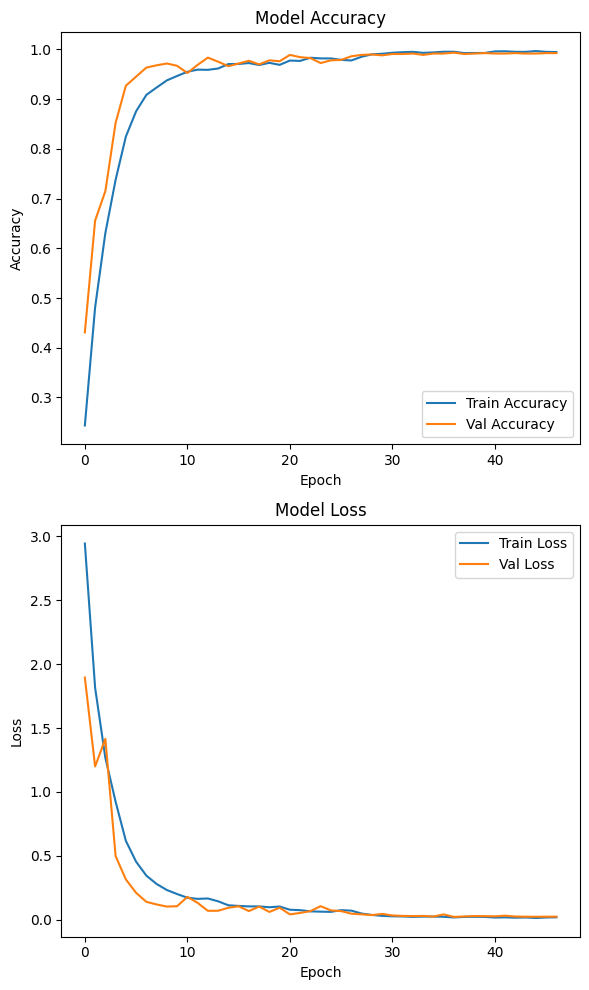

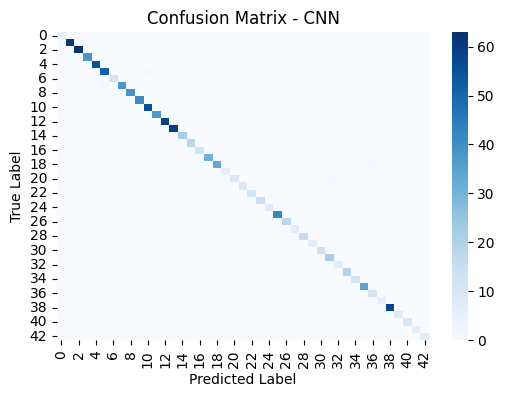

In [22]:
run_training()
predict_and_create_submission()